# Quality Control Drift of Sintela Onyx

This script analyzes the drift of the Sintela Onyx when run without a DC Blocker.

In [1]:
# load modules
import glob
import numpy as np
import matplotlib.pyplot as plt
import h5py
import datetime
import scipy
import os
import pandas as pd

In [2]:
# get all hdf5 file names from given directory
# files = glob.glob('/Users/graeffd/tmp/Samsung_8TB/data_100Hz/*h5')
files = glob.glob('../../../data/lab/Onyx_drift_test/data_1Hz/*h5')
files.sort()
print('{} files in directory'.format(len(files)))

5359 files in directory


In [3]:
# time interval at which we want to read files (in minutes)
t_int = 1#int(len(files)/100)
files_selected = files[::t_int]
print('Looking at the data every {} minutes'.format(t_int))
print('{} files selected'.format(len(files_selected)))

Looking at the data every 10 minutes
536 files selected


In [59]:
# select channels
cha_key = 'quiet'#'noisy' # 'quiet'
channels = {'quiet': (300,700), 'noisy': (800, 1300)}
cha_select = channels[cha_key]
print(cha_select)

(300, 700)


Read in files and calculate the median value for each channel for each file. It should be close to 0.

In [154]:
med_arr = np.full((len(files_selected),cha_select[1]-cha_select[0]), np.nan)
for file_idx in range(len(files_selected)):
    print("File {} of {}".format(file_idx+1, len(files_selected)), end="\r")
    try:
        f = h5py.File(files[file_idx],'r')
        data = np.array(f['Acquisition/Raw[0]/RawData'][:,cha_select[0]:cha_select[1]])
        # attrs = dict(f['Acquisition'].attrs)
        # times = np.array(f['Acquisition/Raw[0]/RawDataTime'])
        med_arr[file_idx,:] = np.nanmedian(data, axis=0)
        f.close()
    except OSError: # something wrong with the file
        pass
    except ValueError: # something wrong with the data
        pass

Data from 536 channels


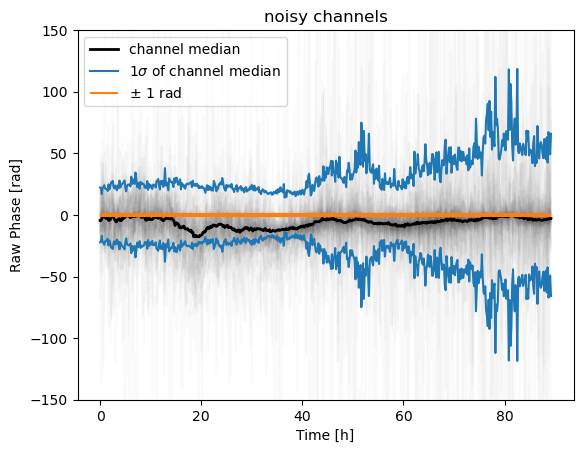

In [155]:
t_axis = np.arange(0,med_arr.shape[0]*t_int/60.,t_int/60.) 
for cha in range(0, med_arr.shape[1], 10):
    plt.plot(t_axis, med_arr[:,cha], color='k', alpha=1/med_arr.shape[1]*10)
plt.plot(t_axis, np.median(med_arr, axis=1), color='k', linewidth=2, label='channel median')
plt.plot(t_axis, np.std(med_arr, axis=1), color='C0', label=r'1$\sigma$ of channel median')
plt.plot(t_axis, -np.std(med_arr, axis=1), color='C0')
plt.hlines([-1,1], 0, np.max(t_axis), color='C1', label=r'$\pm$ 1 rad')
plt.xlabel('Time [h]')
plt.ylabel('Raw Phase [rad]')
plt.title('{} channels'.format(cha_key))
plt.ylim(-150,150)
plt.legend()
print('Data from {} channels'.format(len(files_selected)))

If one sees a drift over time, this would mean that a DC Blocker must be applied in the Optical Engineering of the Sintela Onyx. If not, we should be fine without including a DC Blocker.

## Look into a single channel during a 'big' event

In [6]:
# helper functions
def sintela_to_datetime(sintela_times):
    '''returns an array of datetime.datetime ''' 
    days1970 = datetime.date(1970, 1, 1).toordinal()
    # Vectorize everything
    converttime = np.vectorize(datetime.datetime.fromordinal)
    addday_lambda = lambda x : datetime.timedelta(days=x)
    adddays = np.vectorize(addday_lambda)
    day = days1970 + sintela_times/1e6/60/60/24
    thisDateTime = converttime(np.floor(day).astype(int))
    dayFraction = day-np.floor(day)
    thisDateTime = thisDateTime + adddays(dayFraction)
    return thisDateTime

In [65]:
%matplotlib widget
cha_select = (850,855)
for file_idx in range(len(files)):
    print("File {} of {}".format(file_idx+1, len(files)), end="\r")
    try:
        f = h5py.File(files[file_idx],'r')
        data = np.array(f['Acquisition/Raw[0]/RawData'][:,cha_select[0]:cha_select[1]])
        if file_idx == 0:
            all_data = data
        else:
            all_data = np.concatenate([all_data, data])
        f.close()
    except OSError: # something wrong with the file
        pass
    except ValueError: # something wrong with the data
        pass

/var/folders/2c/_9c95l0j7lq3wm599h6nkywc0000gn/T/ipykernel_30349/3058323361.py:2: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = plt.figure()


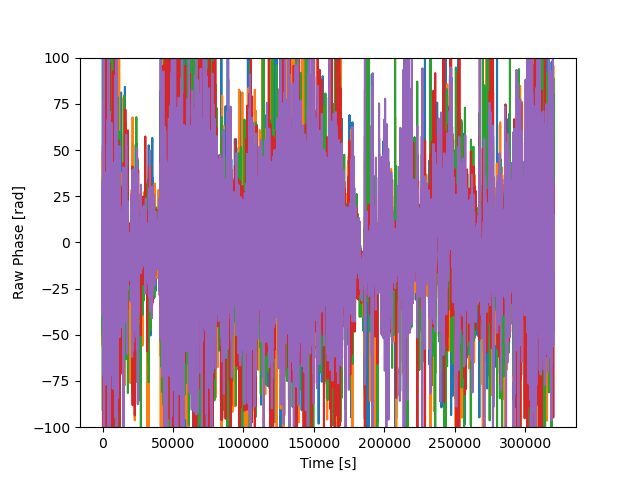

In [70]:
%matplotlib widget
fig = plt.figure()
t_axis = np.arange(0,all_data.shape[0],1) 
for cha in range(0, all_data.shape[1], 1):
    plt.plot(t_axis, all_data[:,cha])#, color='k', alpha=1/all_data.shape[1])
# plt.plot(t_axis, np.mean(all_data, axis=1), color='k', label='channel median')
plt.ylim(-100,100)
plt.xlabel('Time [s]')
plt.ylabel('Raw Phase [rad]')
plt.show()